In [2]:
import pandas as pd
import numpy as np

# Load Data
df = pd.read_csv('../data/train.csv')

print("="*50)
print("       INTENSIVE DATA HEALTH CHECK       ")
print("="*50)

# 1. Basic Info
print("\n--- 1. SHAPE & TYPES ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(df.info())

# 2. Missing Values Deep Dive
print("\n--- 2. MISSING VALUES BREAKDOWN ---")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percent %': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Percent %', ascending=False))

# 3. Duplicates
print("\n--- 3. DUPLICATE RECORDS ---")
print(f"Duplicate Rows: {df.duplicated().sum()}")

# 4. Cardinality (Unique Values)
print("\n--- 4. UNIQUE VALUES (CARDINALITY) ---")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# 5. Target Balance
print("\n--- 5. TARGET VARIABLE DISTRIBUTION ---")
print(df['retention_status'].value_counts(normalize=True) * 100)

# 6. Numerical Stats (Skewness check)
print("\n--- 6. NUMERICAL STATISTICS ---")
print(df.describe().T)

print("\n--- 7. CATEGORICAL BREAKDOWNS (Top 5 per col) ---")
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if col != 'retention_status':
        print(f"\n[{col} Top 5 Categories]")
        print(df[col].value_counts().head(5))

print("\n" + "="*50)
print("       END OF STATISTICAL REPORT       ")
print("="*50)

       INTENSIVE DATA HEALTH CHECK       

--- 1. SHAPE & TYPES ---
Rows: 59611, Columns: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59611 entries, 0 to 59610
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   founder_id                  59611 non-null  int64  
 1   founder_age                 59611 non-null  int64  
 2   founder_gender              59611 non-null  object 
 3   years_with_startup          59611 non-null  int64  
 4   founder_role                59611 non-null  object 
 5   monthly_revenue_generated   57811 non-null  float64
 6   work_life_balance_rating    49467 non-null  object 
 7   venture_satisfaction        52447 non-null  object 
 8   startup_performance_rating  59611 non-null  object 
 9   funding_rounds_led          59611 non-null  int64  
 10  working_overtime            59611 non-null  object 
 11  distance_from_investor_hub  59611 non-null  int64  


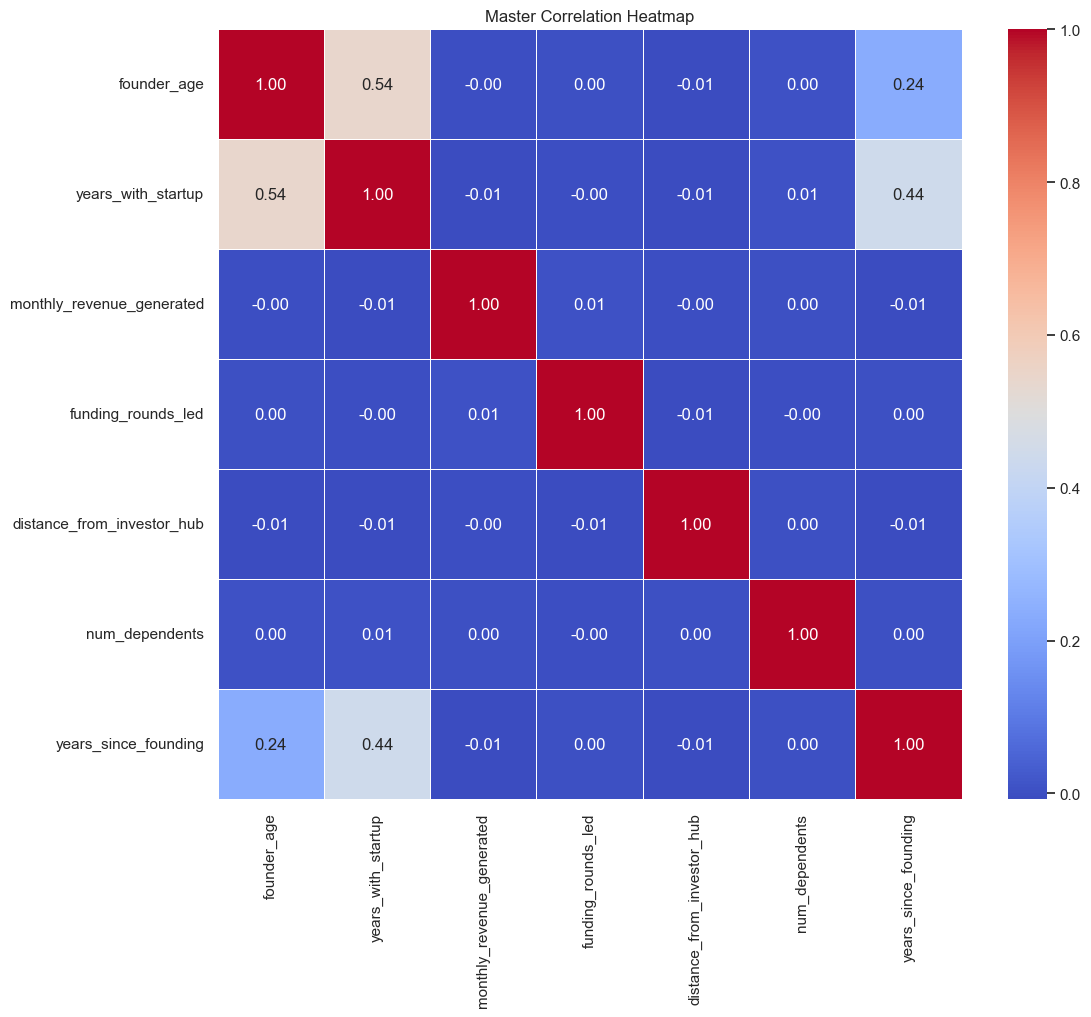

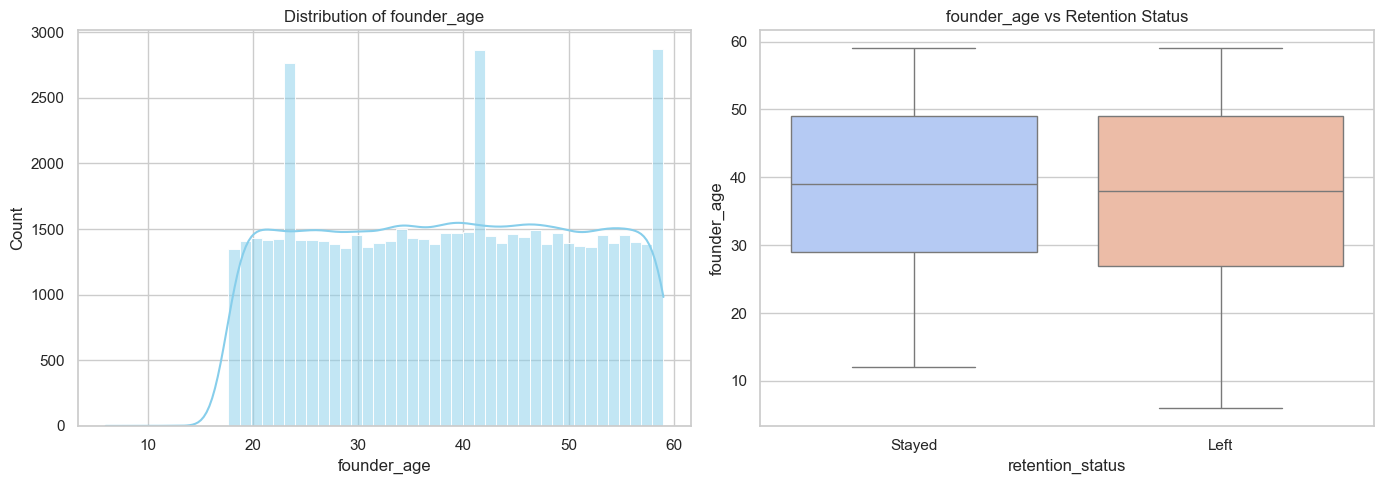

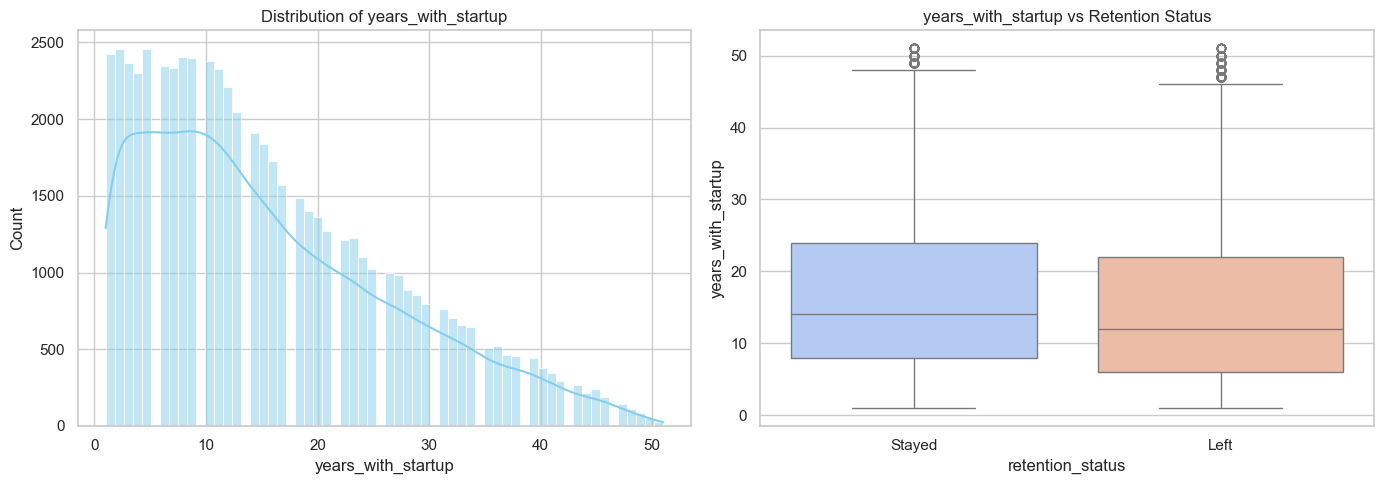

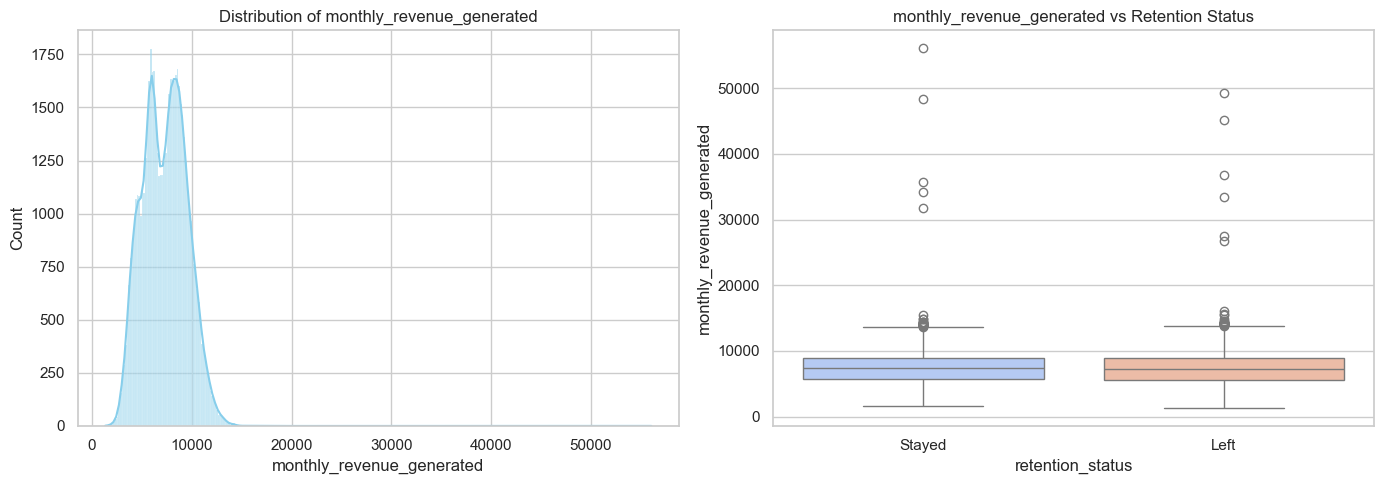

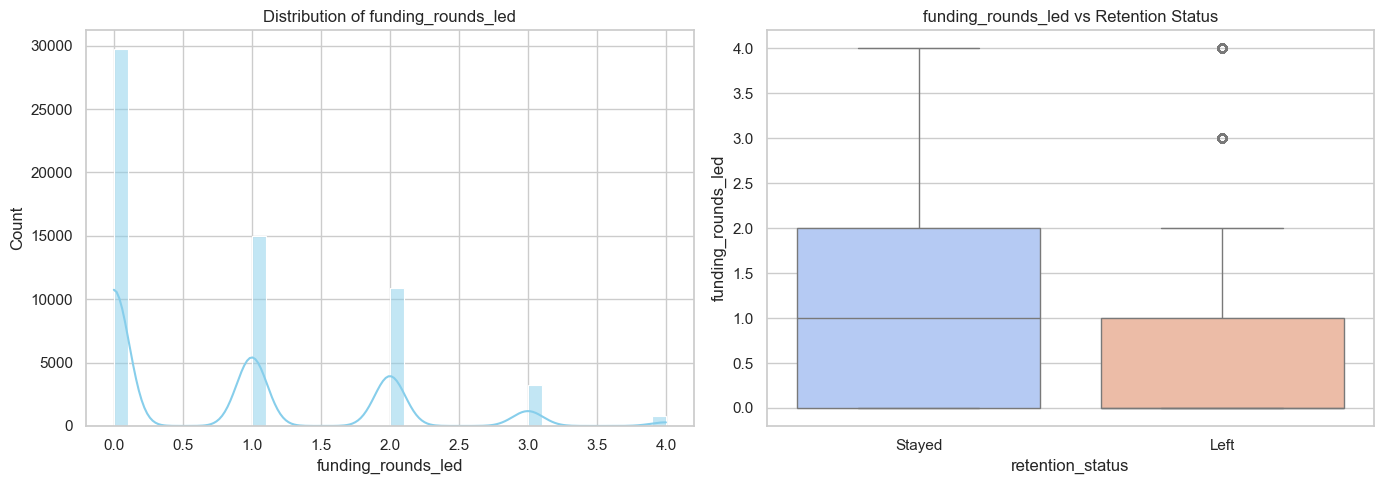

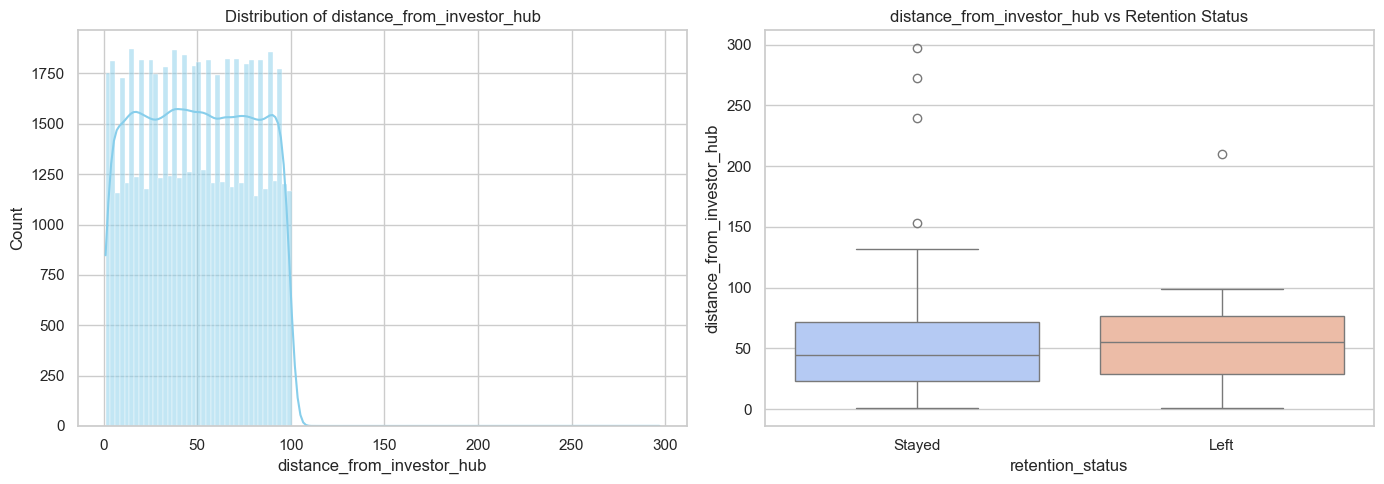

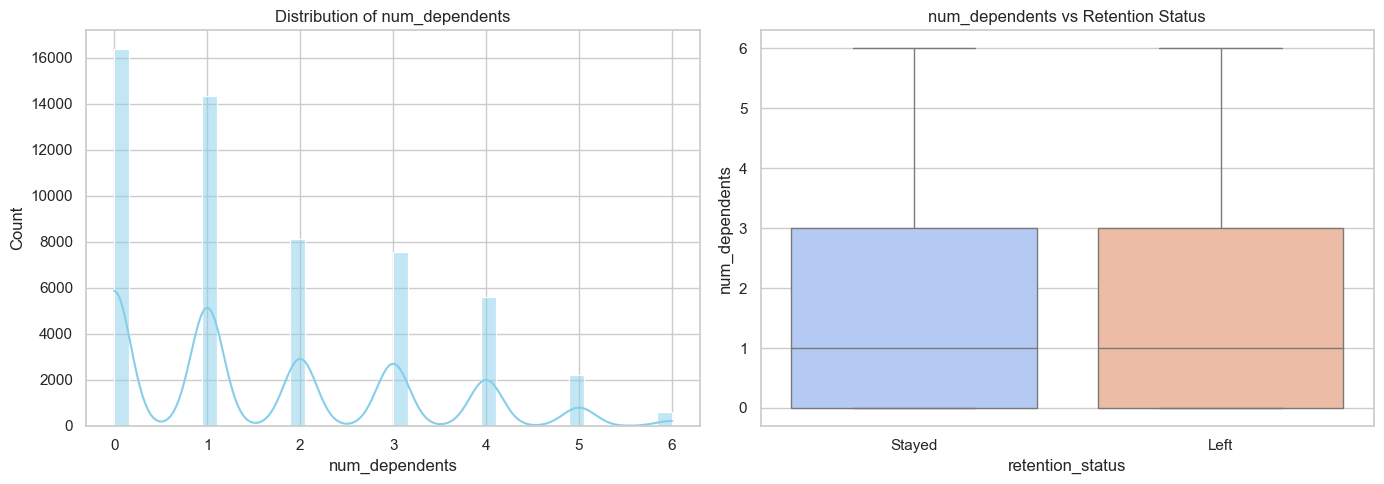

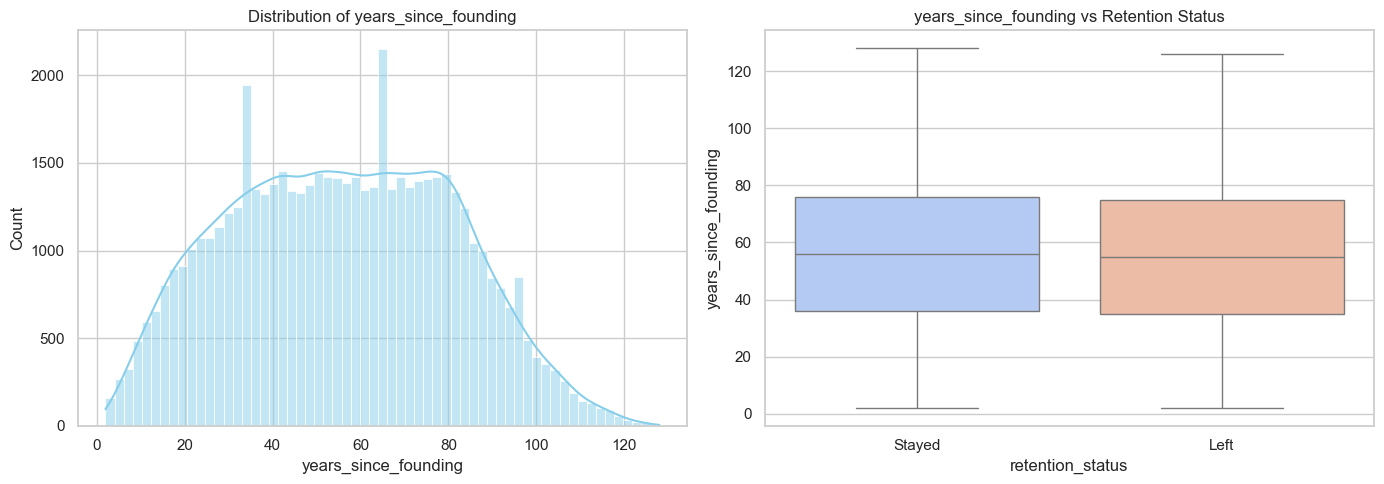

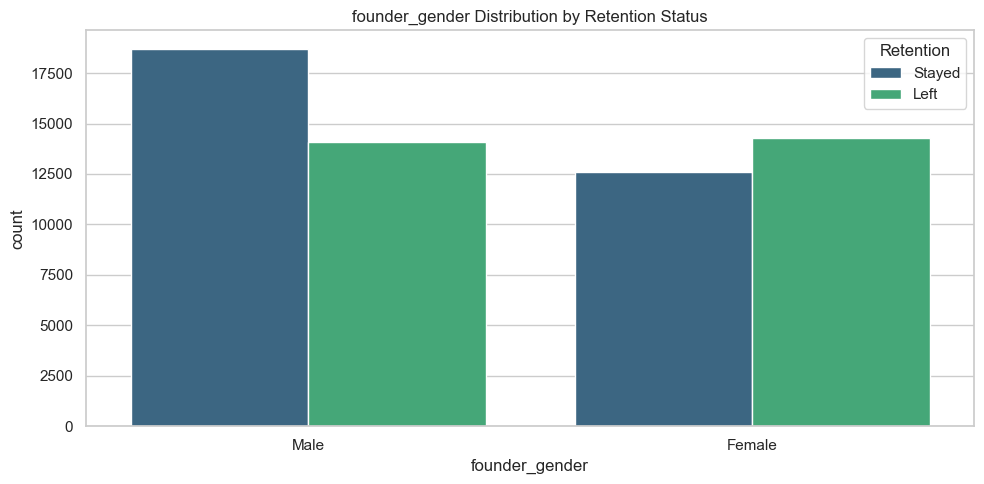

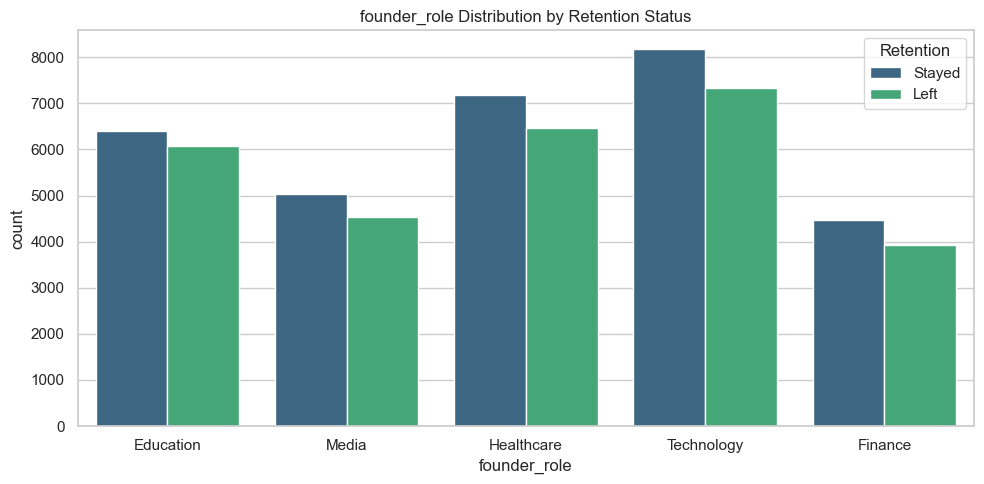

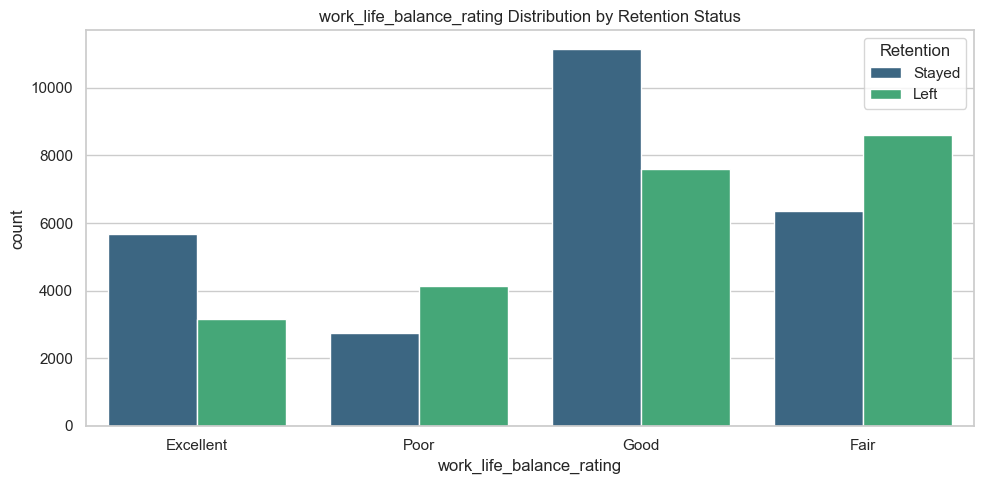

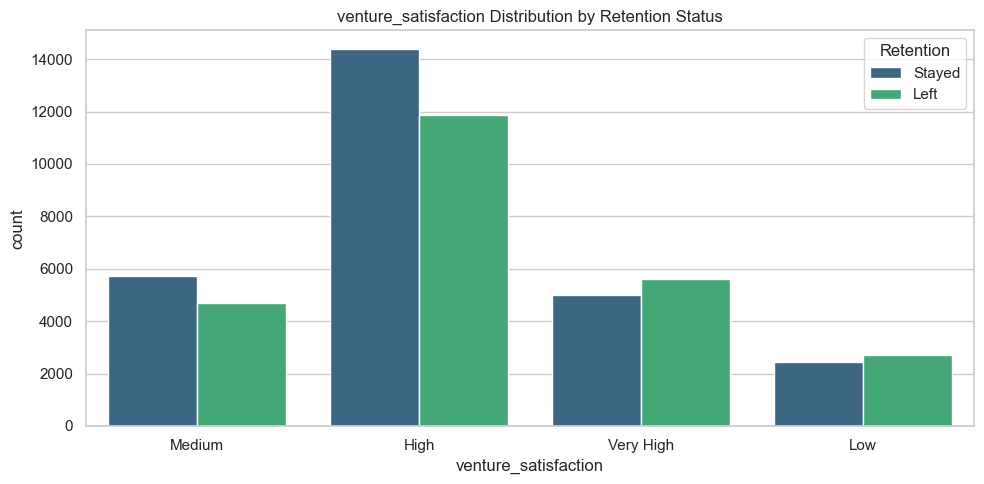

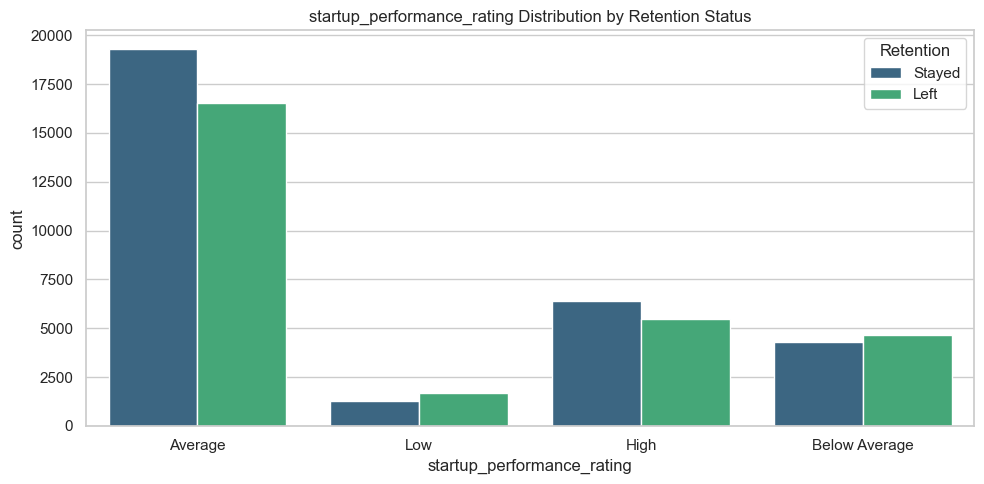

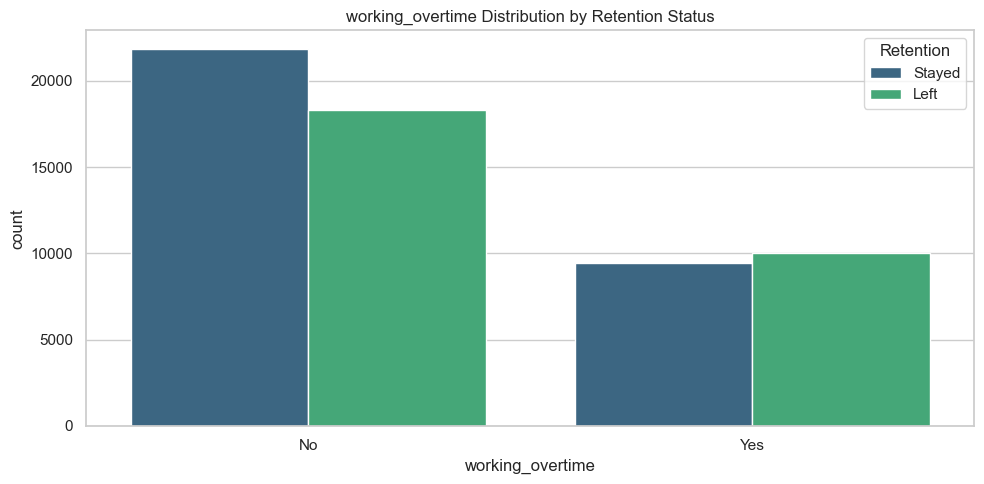

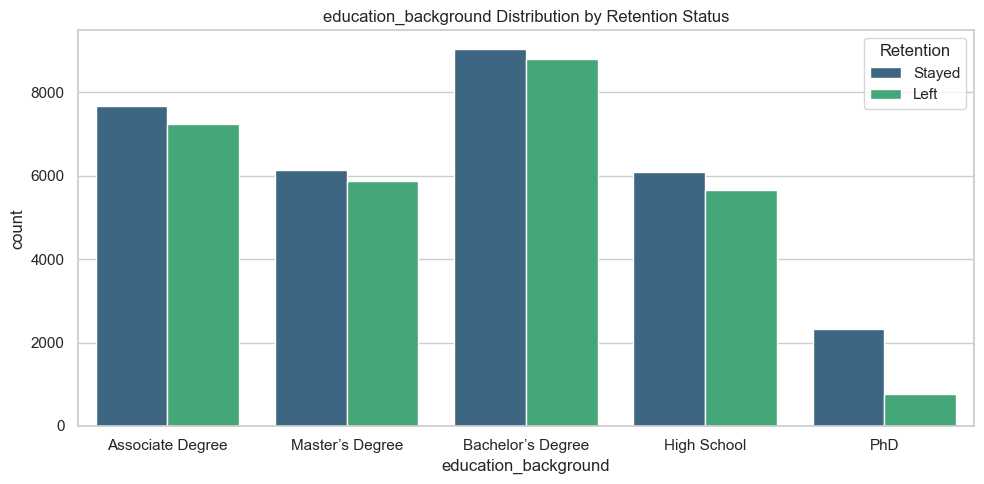

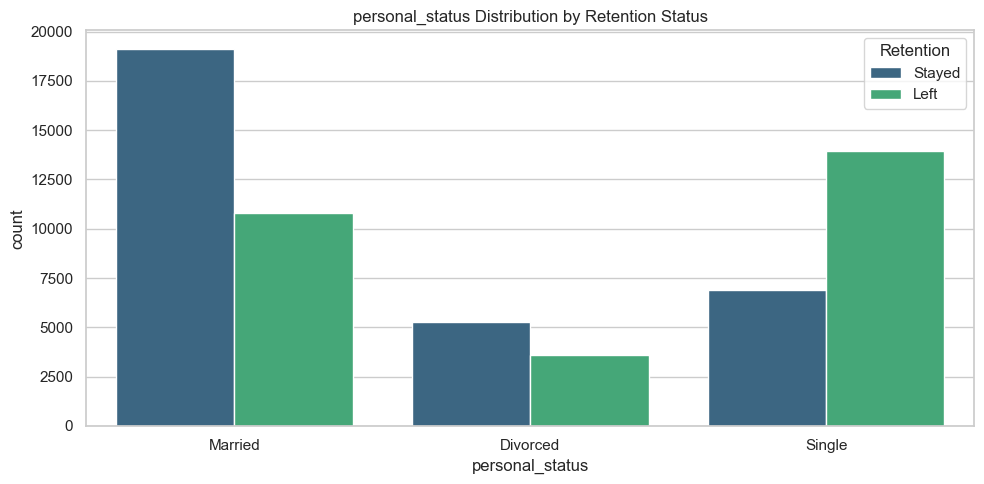

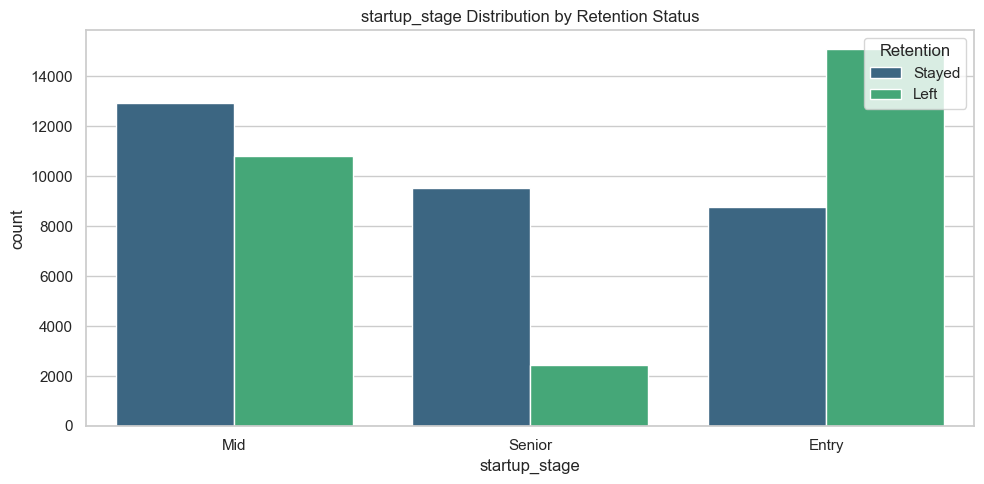

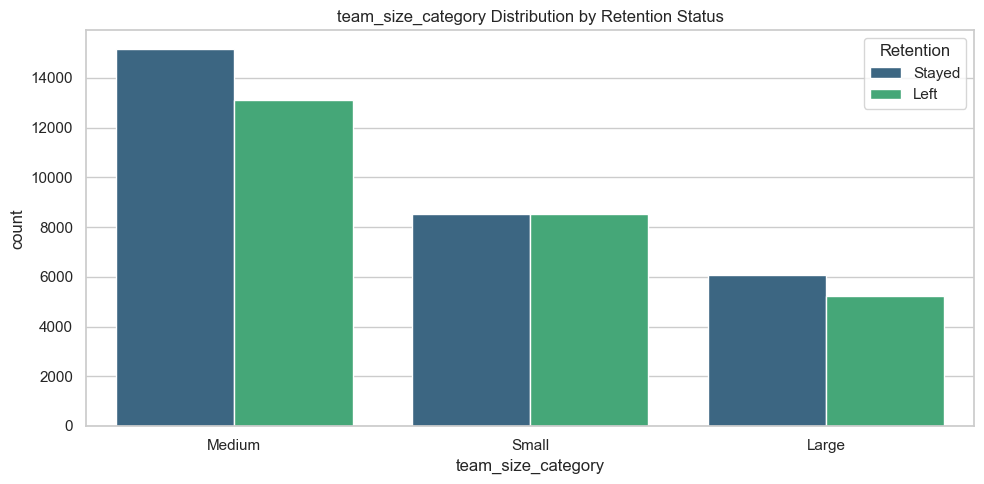

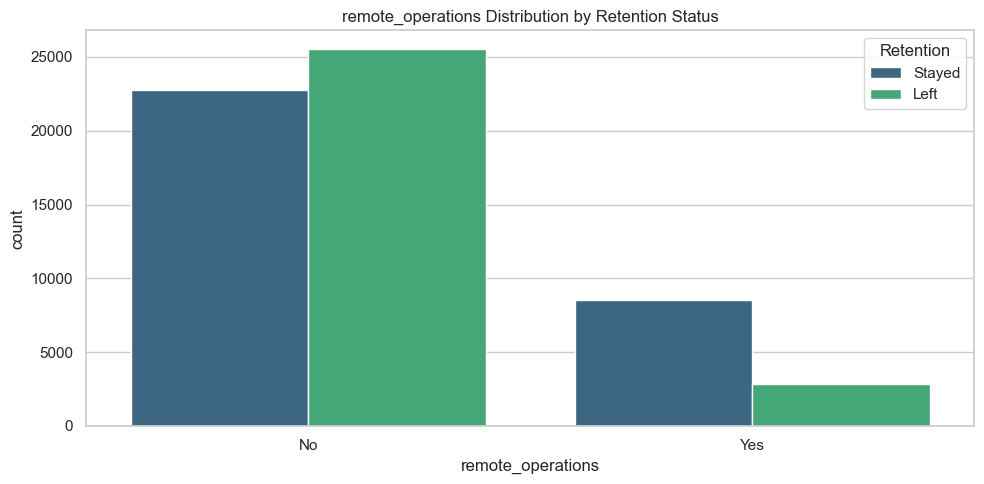

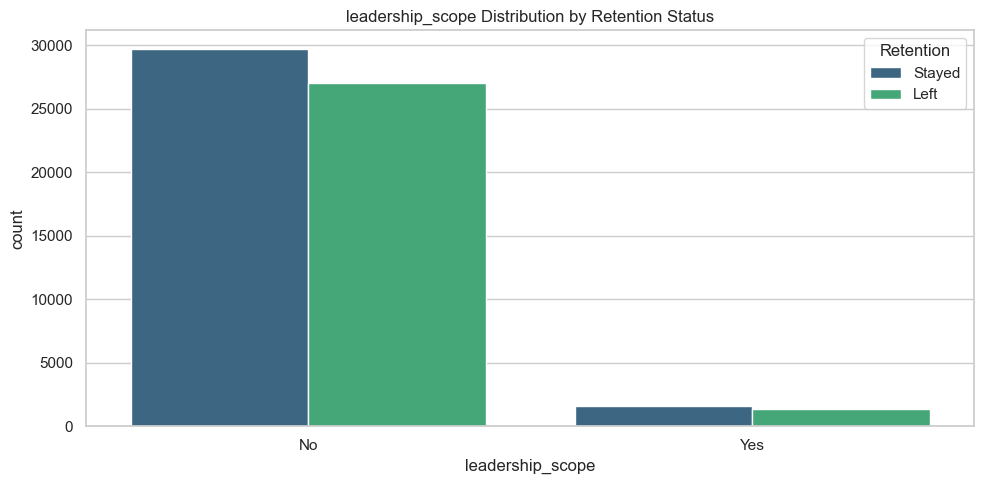

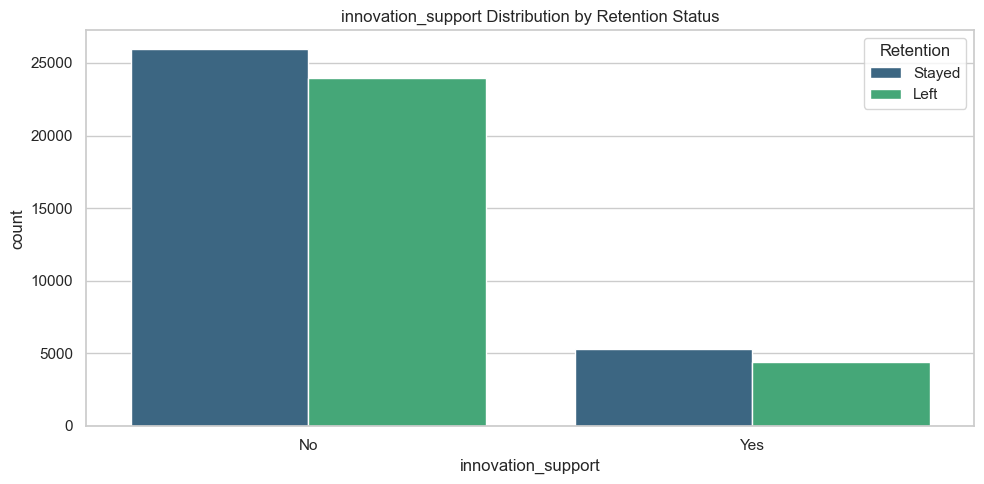

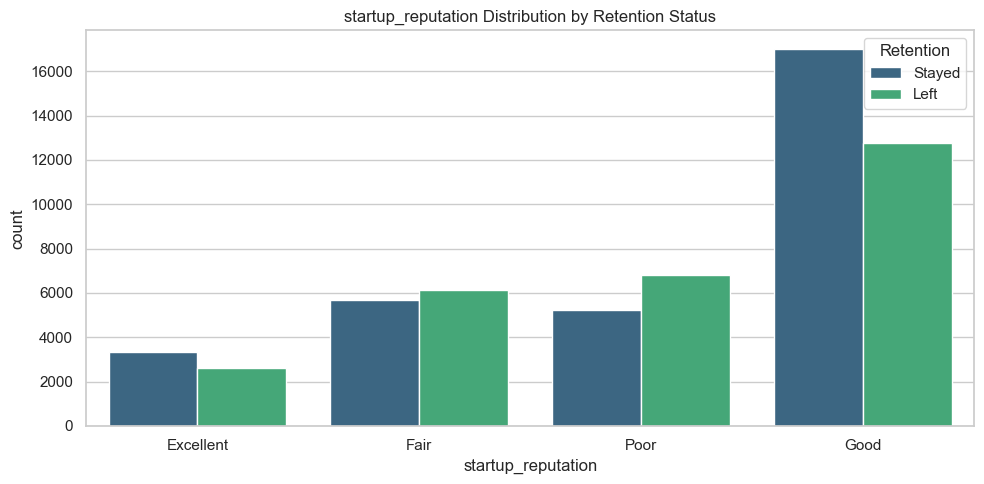

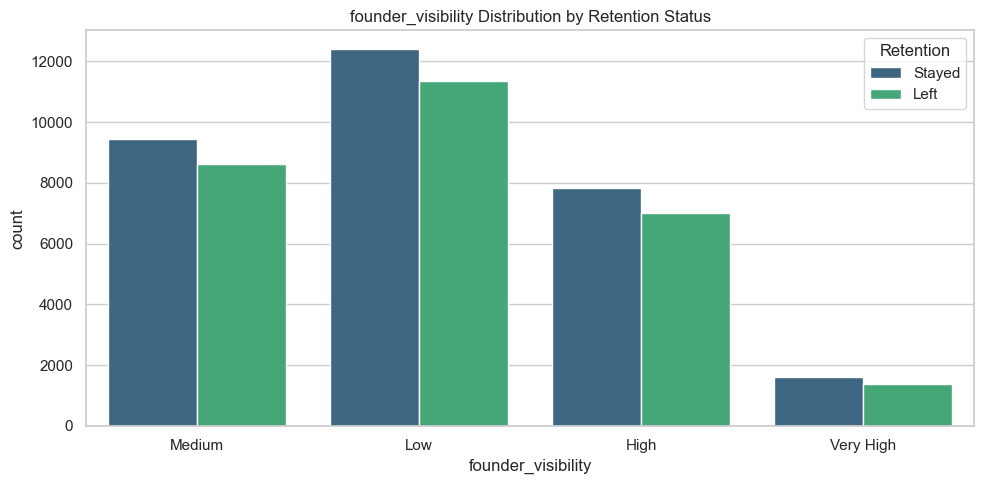

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style="whitegrid")
# Filter out ID column for plotting
plot_df = df.drop(columns=['founder_id'], errors='ignore')

# --- A. NUMERICAL VARIABLES ANALYSIS ---
num_cols = plot_df.select_dtypes(include=['float64', 'int64']).columns

# 1. Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(plot_df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Master Correlation Heatmap')
plt.show()

# 2. Distributions & Boxplots (Loop)
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram (Distribution)
    sns.histplot(data=plot_df, x=col, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {col}')
    
    # Boxplot vs Target (Outliers & Separation)
    sns.boxplot(data=plot_df, x='retention_status', y=col, hue='retention_status', legend=False, palette='coolwarm', ax=axes[1])
    axes[1].set_title(f'{col} vs Retention Status')
    
    plt.tight_layout()
    plt.show()

# --- B. CATEGORICAL VARIABLES ANALYSIS ---
cat_cols = plot_df.select_dtypes(include=['object']).columns
# Remove target from this list so we don't plot it against itself
cat_cols = [c for c in cat_cols if c != 'retention_status']

for col in cat_cols:
    plt.figure(figsize=(10, 5))
    
    # Countplot split by Target
    # If too many categories, rotate x-axis
    if plot_df[col].nunique() > 10:
        plt.xticks(rotation=45, ha='right')
        
    sns.countplot(data=plot_df, x=col, hue='retention_status', palette='viridis')
    plt.title(f'{col} Distribution by Retention Status')
    plt.legend(title='Retention', loc='upper right')
    plt.tight_layout()
    plt.show()

In [ ]:

# Load the data (assuming you are in the same session)
# df = pd.read_csv('data/train.csv') # Uncomment if you need to reload

def clean_data(df):
    # 1. Drop Duplicates
    df = df.drop_duplicates()
    
    # 2. Anomaly Removal
    # Keep only founders 18 or older
    df = df[df['founder_age'] >= 18]
    
    # Keep only valid tenures (started at age 16+)
    df = df[(df['founder_age'] - df['years_with_startup']) >= 16]
    
    # 3. Missing Value Imputation
    # Numerical: Median (robust to outliers)
    num_cols = ['monthly_revenue_generated', 'years_since_founding', 'num_dependents']
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
        
    # Categorical: Treat "Missing" as "Unknown" for psychological surveys
    # This captures the "silence" signal
    df['work_life_balance_rating'] = df['work_life_balance_rating'].fillna('Unknown')
    df['venture_satisfaction'] = df['venture_satisfaction'].fillna('Unknown')
    
    # For other structural columns, use Mode
    df['team_size_category'] = df['team_size_category'].fillna(df['team_size_category'].mode()[0])
    
    # 4. Feature Engineering (Simplification)
    # Create a "Start Age" feature to capture the age they started
    df['start_age'] = df['founder_age'] - df['years_with_startup']
    
    # 5. Encoding Target
    # Stayed -> 0, Left -> 1 (Standard for Churn/Exit prediction)
    target_map = {'Stayed': 0, 'Left': 1}
    df['target'] = df['retention_status'].map(target_map)
    
    # Drop unused columns
    cols_to_drop = ['founder_id', 'retention_status']
    df = df.drop(columns=cols_to_drop)
    
    return df

# Apply the cleaning
df_clean = clean_data(df)

print("Data Cleaned Successfully!")
print(f"New Shape: {df_clean.shape}")
print(df_clean.head())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def encode_and_split(df):
    # --- 1. ORDINAL ENCODING (Preserving Order) ---
    # We manually map these so the model knows 'Excellent' is better than 'Poor'
    
    rating_map = {'Unknown': 0, 'Low': 1, 'Poor': 1, 'Below Average': 2, 
                  'Fair': 3, 'Medium': 3, 'Average': 3, 
                  'Good': 4, 'High': 4, 'Very High': 5, 'Excellent': 5}
    
    # Apply to all rating-like columns
    ord_cols = ['work_life_balance_rating', 'venture_satisfaction', 
                'startup_performance_rating', 'startup_reputation', 'founder_visibility']
    
    for col in ord_cols:
        # Map and fill any unexpected values with 0 (Unknown)
        df[col] = df[col].map(rating_map).fillna(0)

    # Map Binary Columns (Yes/No)
    binary_map = {'No': 0, 'Yes': 1}
    bin_cols = ['working_overtime', 'remote_operations', 'innovation_support', 'leadership_scope']
    for col in bin_cols:
        df[col] = df[col].map(binary_map)

    # Map Startup Stage (Roughly ordered)
    stage_map = {'Entry': 1, 'Mid': 2, 'Senior': 3, 'Growth': 3, 'Established': 4}
    df['startup_stage'] = df['startup_stage'].map(stage_map).fillna(1)

    # --- 2. ONE-HOT ENCODING (Nominal Data) ---
    # For Gender, Role, Education, etc.
    # drop_first=True helps avoid multicollinearity (redundancy)
    df = pd.get_dummies(df, columns=['founder_gender', 'founder_role', 
                                     'education_background', 'personal_status', 
                                     'team_size_category'], drop_first=True)

    # --- 3. SPLITTING ---
    X = df.drop('target', axis=1)
    y = df['target']
    
    # 80% Train, 20% Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # --- 4. SCALING ---
    # Scale numerical features so age (e.g., 40) doesn't get overpowered by revenue (e.g., 5000)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to dataframe for readability (optional but helpful)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)
    
    return X_train_final, X_test_final, y_train, y_test

# Execute
X_train, X_test, y_train, y_test = encode_and_split(df_clean)

print("Data Transformation Complete!")
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print("\nFirst 5 rows of processed data (All Numbers Now!):")
print(X_train.head())

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Logistic Regression (The Baseline) ---
print("Training Logistic Regression...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# --- 2. Random Forest (The Complex Model) ---
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --- 3. Evaluation Helper Function ---
def evaluate_model(y_test, y_pred, model_name):
    print("="*40)
    print(f"   {model_name} PERFORMANCE")
    print("="*40)
    
    # Basic Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score: {acc:.2%}")
    
    # Detailed Report (Precision/Recall)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Stayed (0)', 'Left (1)']))
    
    # Visual Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name}: Confusion Matrix')
    plt.ylabel('Actual Truth')
    plt.xlabel('Model Prediction')
    plt.show()

# Run the comparisons
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Feature Importance (What mattered most?)
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

print("\n--- Top 10 Factors Driving Retention ---")
print(feature_importances)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Starting Grid Search... (This may take a few minutes)")

# 1. Define the Parameter Grid (The "Knobs" to turn)
param_grid = {
    'n_estimators': [100, 200],        # How many trees?
    'max_depth': [10, 20, None],       # How deep can they grow?
    'min_samples_split': [2, 5, 10],   # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum samples at the end of a branch
}

# 2. Initialize Grid Search
# cv=3 means "Cross-Validation": it splits training data 3 ways to verify results internally
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# 3. Fit to Training Data
grid_search.fit(X_train, y_train)

# 4. Get the Best Model
best_rf = grid_search.best_estimator_
print("\nBest Parameters Found:")
print(grid_search.best_params_)

# 5. Evaluate the Tuned Model
print("\nEvaluating Tuned Model on Test Set...")
y_pred_tuned = best_rf.predict(X_test)

# Calculate Metrics
acc = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned Random Forest Accuracy: {acc:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Stayed (0)', 'Left (1)']))

# 6. Compare with Baseline (Visual)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Greens')
plt.title(f'Tuned Random Forest (Acc: {acc:.2%})')
plt.ylabel('Actual Truth')
plt.xlabel('Model Prediction')
plt.show()

In [ ]:
# --- FINAL SUBMISSION PIPELINE ---

# 1. Load Data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

# Combine to ensure One-Hot Encoding is identical for both
train['is_train'] = 1
test['is_train'] = 0
test['retention_status'] = 'Unknown' # Placeholder
combined = pd.concat([train, test], axis=0)

# 2. Apply the EXACT same cleaning as before
def process_data(df):
    # Drop duplicates (Only for train, be careful with test IDs!)
    # Actually, for submission, we usually keep test rows as-is to match IDs.
    
    # Cleaning
    df['founder_age'] = df['founder_age'].clip(lower=18) # Fix underage instead of dropping
    
    # Imputing
    num_cols = ['monthly_revenue_generated', 'years_since_founding', 'num_dependents']
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
        
    df['work_life_balance_rating'] = df['work_life_balance_rating'].fillna('Unknown')
    df['venture_satisfaction'] = df['venture_satisfaction'].fillna('Unknown')
    df['team_size_category'] = df['team_size_category'].fillna(df['team_size_category'].mode()[0])
    
    # Feature Engineering
    df['start_age'] = df['founder_age'] - df['years_with_startup']
    
    # Ordinal Encoding
    rating_map = {'Unknown': 0, 'Low': 1, 'Poor': 1, 'Below Average': 2, 
                  'Fair': 3, 'Medium': 3, 'Average': 3, 
                  'Good': 4, 'High': 4, 'Very High': 5, 'Excellent': 5}
    ord_cols = ['work_life_balance_rating', 'venture_satisfaction', 
                'startup_performance_rating', 'startup_reputation', 'founder_visibility']
    for col in ord_cols:
        df[col] = df[col].map(rating_map).fillna(0)

    binary_map = {'No': 0, 'Yes': 1}
    bin_cols = ['working_overtime', 'remote_operations', 'innovation_support', 'leadership_scope']
    for col in bin_cols:
        df[col] = df[col].map(binary_map)

    stage_map = {'Entry': 1, 'Mid': 2, 'Senior': 3, 'Growth': 3, 'Established': 4}
    df['startup_stage'] = df['startup_stage'].map(stage_map).fillna(1)
    
    # One-Hot Encoding
    df = pd.get_dummies(df, columns=['founder_gender', 'founder_role', 
                                     'education_background', 'personal_status', 
                                     'team_size_category'], drop_first=True)
    
    return df

# Process the combined dataframe
combined_processed = process_data(combined)

# 3. Split back into Train and Test
train_final = combined_processed[combined_processed['is_train'] == 1].drop(columns=['is_train', 'founder_id'])
test_final = combined_processed[combined_processed['is_train'] == 0].drop(columns=['is_train', 'retention_status'])

# Target preparation
target_map = {'Stayed': 0, 'Left': 1}
y = train_final['retention_status'].map(target_map)
X = train_final.drop(columns=['retention_status'])

# Ensure Test has same columns as Train
X_test_submit = test_final[X.columns] # Reorder/filter columns

# 4. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_submit_scaled = scaler.transform(X_test_submit)

# 5. Train the BEST Model (Tuned Random Forest)
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
print("Training Final Model on Full Data...")
final_model.fit(X_scaled, y)

# 6. Predict
predictions = final_model.predict(X_test_submit_scaled)

# 7. Create Submission File
# Map back to original labels if required, or use 0/1? 
# Sample submission usually wants the class label. Let's check sample_sub.
# The prompt showed: "Left" and "Stayed". We must map back!

inverse_map = {0: 'Stayed', 1: 'Left'}
submission_df = pd.DataFrame({
    'founder_id': test['founder_id'],
    'retention_status': [inverse_map[p] for p in predictions]
})

submission_df.to_csv('submission.csv', index=False)
print("Success! 'submission.csv' saved.")
print(submission_df.head())

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Training Gradient Boosting Model...")

# 1. Initialize the Model
# key params: learning_rate (how fast it learns), n_estimators (trees), max_depth (keep small!)
gbm = GradientBoostingClassifier(
    n_estimators=200, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

# 2. Train
gbm.fit(X_train, y_train)

# 3. Predict
y_pred_gbm = gbm.predict(X_test)

# 4. Evaluate
gbm_acc = accuracy_score(y_test, y_pred_gbm)
print(f"Gradient Boosting Accuracy: {gbm_acc:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbm, target_names=['Stayed (0)', 'Left (1)']))

# 5. Visual Comparison (GBM Confusion Matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gbm), annot=True, fmt='d', cmap='Oranges')
plt.title(f'Gradient Boosting (Acc: {gbm_acc:.2%})')
plt.ylabel('Actual Truth')
plt.xlabel('Model Prediction')
plt.show()

In [ ]:
# --- SUBMISSION WITH GBM ---

print("Retraining GBM on Full Data and generating submission...")

# 1. Train on ALL data (X_scaled from previous step)
final_gbm = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
final_gbm.fit(X_scaled, y)

# 2. Predict on Test Set
gbm_predictions = final_gbm.predict(X_test_submit_scaled)

# 3. Save File
inverse_map = {0: 'Stayed', 1: 'Left'}
submission_gbm = pd.DataFrame({
    'founder_id': test['founder_id'],
    'retention_status': [inverse_map[p] for p in gbm_predictions]
})

submission_gbm.to_csv('submission_gbm.csv', index=False)
print("Success! 'submission_gbm.csv' saved.")

In [ ]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Support Vector Machine (SVM) ---
print("Training SVM... (This might take a few minutes, grab a coffee ☕)")
# kernel='rbf' allows it to fit non-linear curves
# C=1.0 is the penalty parameter (Higher C = strict margin, Lower C = soft margin)
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train, y_train) # Make sure to use the SCALED X_train!

y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc:.2%}")

# --- 2. Neural Network (MLP) ---
print("\nTraining Neural Network...")
# hidden_layer_sizes=(64, 32): Two layers with 64 and 32 neurons
# max_iter=500: Allow it enough time to learn (converge)
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), 
                          activation='relu', 
                          solver='adam', 
                          max_iter=500, 
                          random_state=42)
mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)
print(f"Neural Network Accuracy: {mlp_acc:.2%}")

# --- 3. Quick Comparison Report ---
print("\n" + "="*30)
print("     MODEL LEADERBOARD     ")
print("="*30)
print(f"Gradient Boosting (Prev):  (Check your previous output)") 
print(f"Random Forest (Tuned):     74.16%")
print(f"Support Vector Machine:    {svm_acc:.2%}")
print(f"Neural Network (MLP):      {mlp_acc:.2%}")

In [ ]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pandas as pd

# Note: This assumes 'X_scaled', 'y', 'X_test_submit_scaled', and 'test' 
# are already defined from the previous data preparation step.

inverse_map = {0: 'Stayed', 1: 'Left'}

# --- 1. SUBMISSION FOR SVM ---
print("Training SVM on Full Data... (This will take a few minutes)")
final_svm = SVC(kernel='rbf', C=1.0, random_state=42)
final_svm.fit(X_scaled, y)

# Predict
svm_predictions = final_svm.predict(X_test_submit_scaled)

# Save
submission_svm = pd.DataFrame({
    'founder_id': test['founder_id'],
    'retention_status': [inverse_map[p] for p in svm_predictions]
})
submission_svm.to_csv('submission_svm.csv', index=False)
print("Success! 'submission_svm.csv' saved.")


# --- 2. SUBMISSION FOR NEURAL NETWORK ---
print("\nTraining Neural Network on Full Data...")
final_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    random_state=42
)
final_mlp.fit(X_scaled, y)

# Predict
mlp_predictions = final_mlp.predict(X_test_submit_scaled)

# Save
submission_mlp = pd.DataFrame({
    'founder_id': test['founder_id'],
    'retention_status': [inverse_map[p] for p in mlp_predictions]
})
submission_mlp.to_csv('submission_neural_network.csv', index=False)
print("Success! 'submission_neural_network.csv' saved.")